In [ ]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt

In [ ]:
NUM_RUNS = 10

A = 128       # Example values for layer size
B = 2       # Example values for number of layers
C = 0.0002     # Learning rate
D = 10000      # Example values for replay buffer size
E = 500       # Example values for num_episodes
F = 1.0          # Example values for epsilon start value
G = 1.0         # Reward normalization factor
H = 64        # Minimum buffer size and Batch Size
I = 100       # Target network update frequency

eps_decay = float(1 / E)

## RUN 10 TIMES

In [ ]:
runs_results = []

env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    layers = [4] + [A]*B + [2]
    policy_net = DQN(layers)
    target_net = DQN(layers)
    update_target(target_net, policy_net)
    target_net.eval()

    optimizer = optim.AdamW(policy_net.parameters(), lr=C)
    memory = ReplayBuffer(D)

    steps_done = 0

    episode_durations = []
    F = 1.0
    for i_episode in range(E):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", 500)

        observation = env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            F = max(F*eps_decay, 0.005)
            action = epsilon_greedy(F, policy_net, state)
            observation, reward, done, terminated = env.step(action)
            reward = torch.tensor([reward])/G
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < H:
                transitions = memory.sample(H)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()

            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
            steps_done += 1
            # Update the target network, copying all weights and biases in DQN
            if steps_done % I == 0:
                update_target(target_net, policy_net)
    runs_results.append(episode_durations)
print('Complete')

Starting run 1 of 10
episode  50 / 500
episode  100 / 500
episode  150 / 500
episode  200 / 500
episode  250 / 500
episode  300 / 500
episode  350 / 500
episode  400 / 500
episode  450 / 500
episode  500 / 500
Starting run 2 of 10
episode  50 / 500
episode  100 / 500
episode  150 / 500
episode  200 / 500
episode  250 / 500
episode  300 / 500
episode  350 / 500
episode  400 / 500
episode  450 / 500
episode  500 / 500
Starting run 3 of 10
episode  50 / 500
episode  100 / 500
episode  150 / 500
episode  200 / 500
episode  250 / 500
episode  300 / 500
episode  350 / 500
episode  400 / 500
episode  450 / 500
episode  500 / 500
Starting run 4 of 10
episode  50 / 500
episode  100 / 500
episode  150 / 500
episode  200 / 500
episode  250 / 500
episode  300 / 500
episode  350 / 500
episode  400 / 500
episode  450 / 500
episode  500 / 500
Starting run 5 of 10
episode  50 / 500
episode  100 / 500
episode  150 / 500
episode  200 / 500
episode  250 / 500
episode  300 / 500
episode  350 / 500
episode

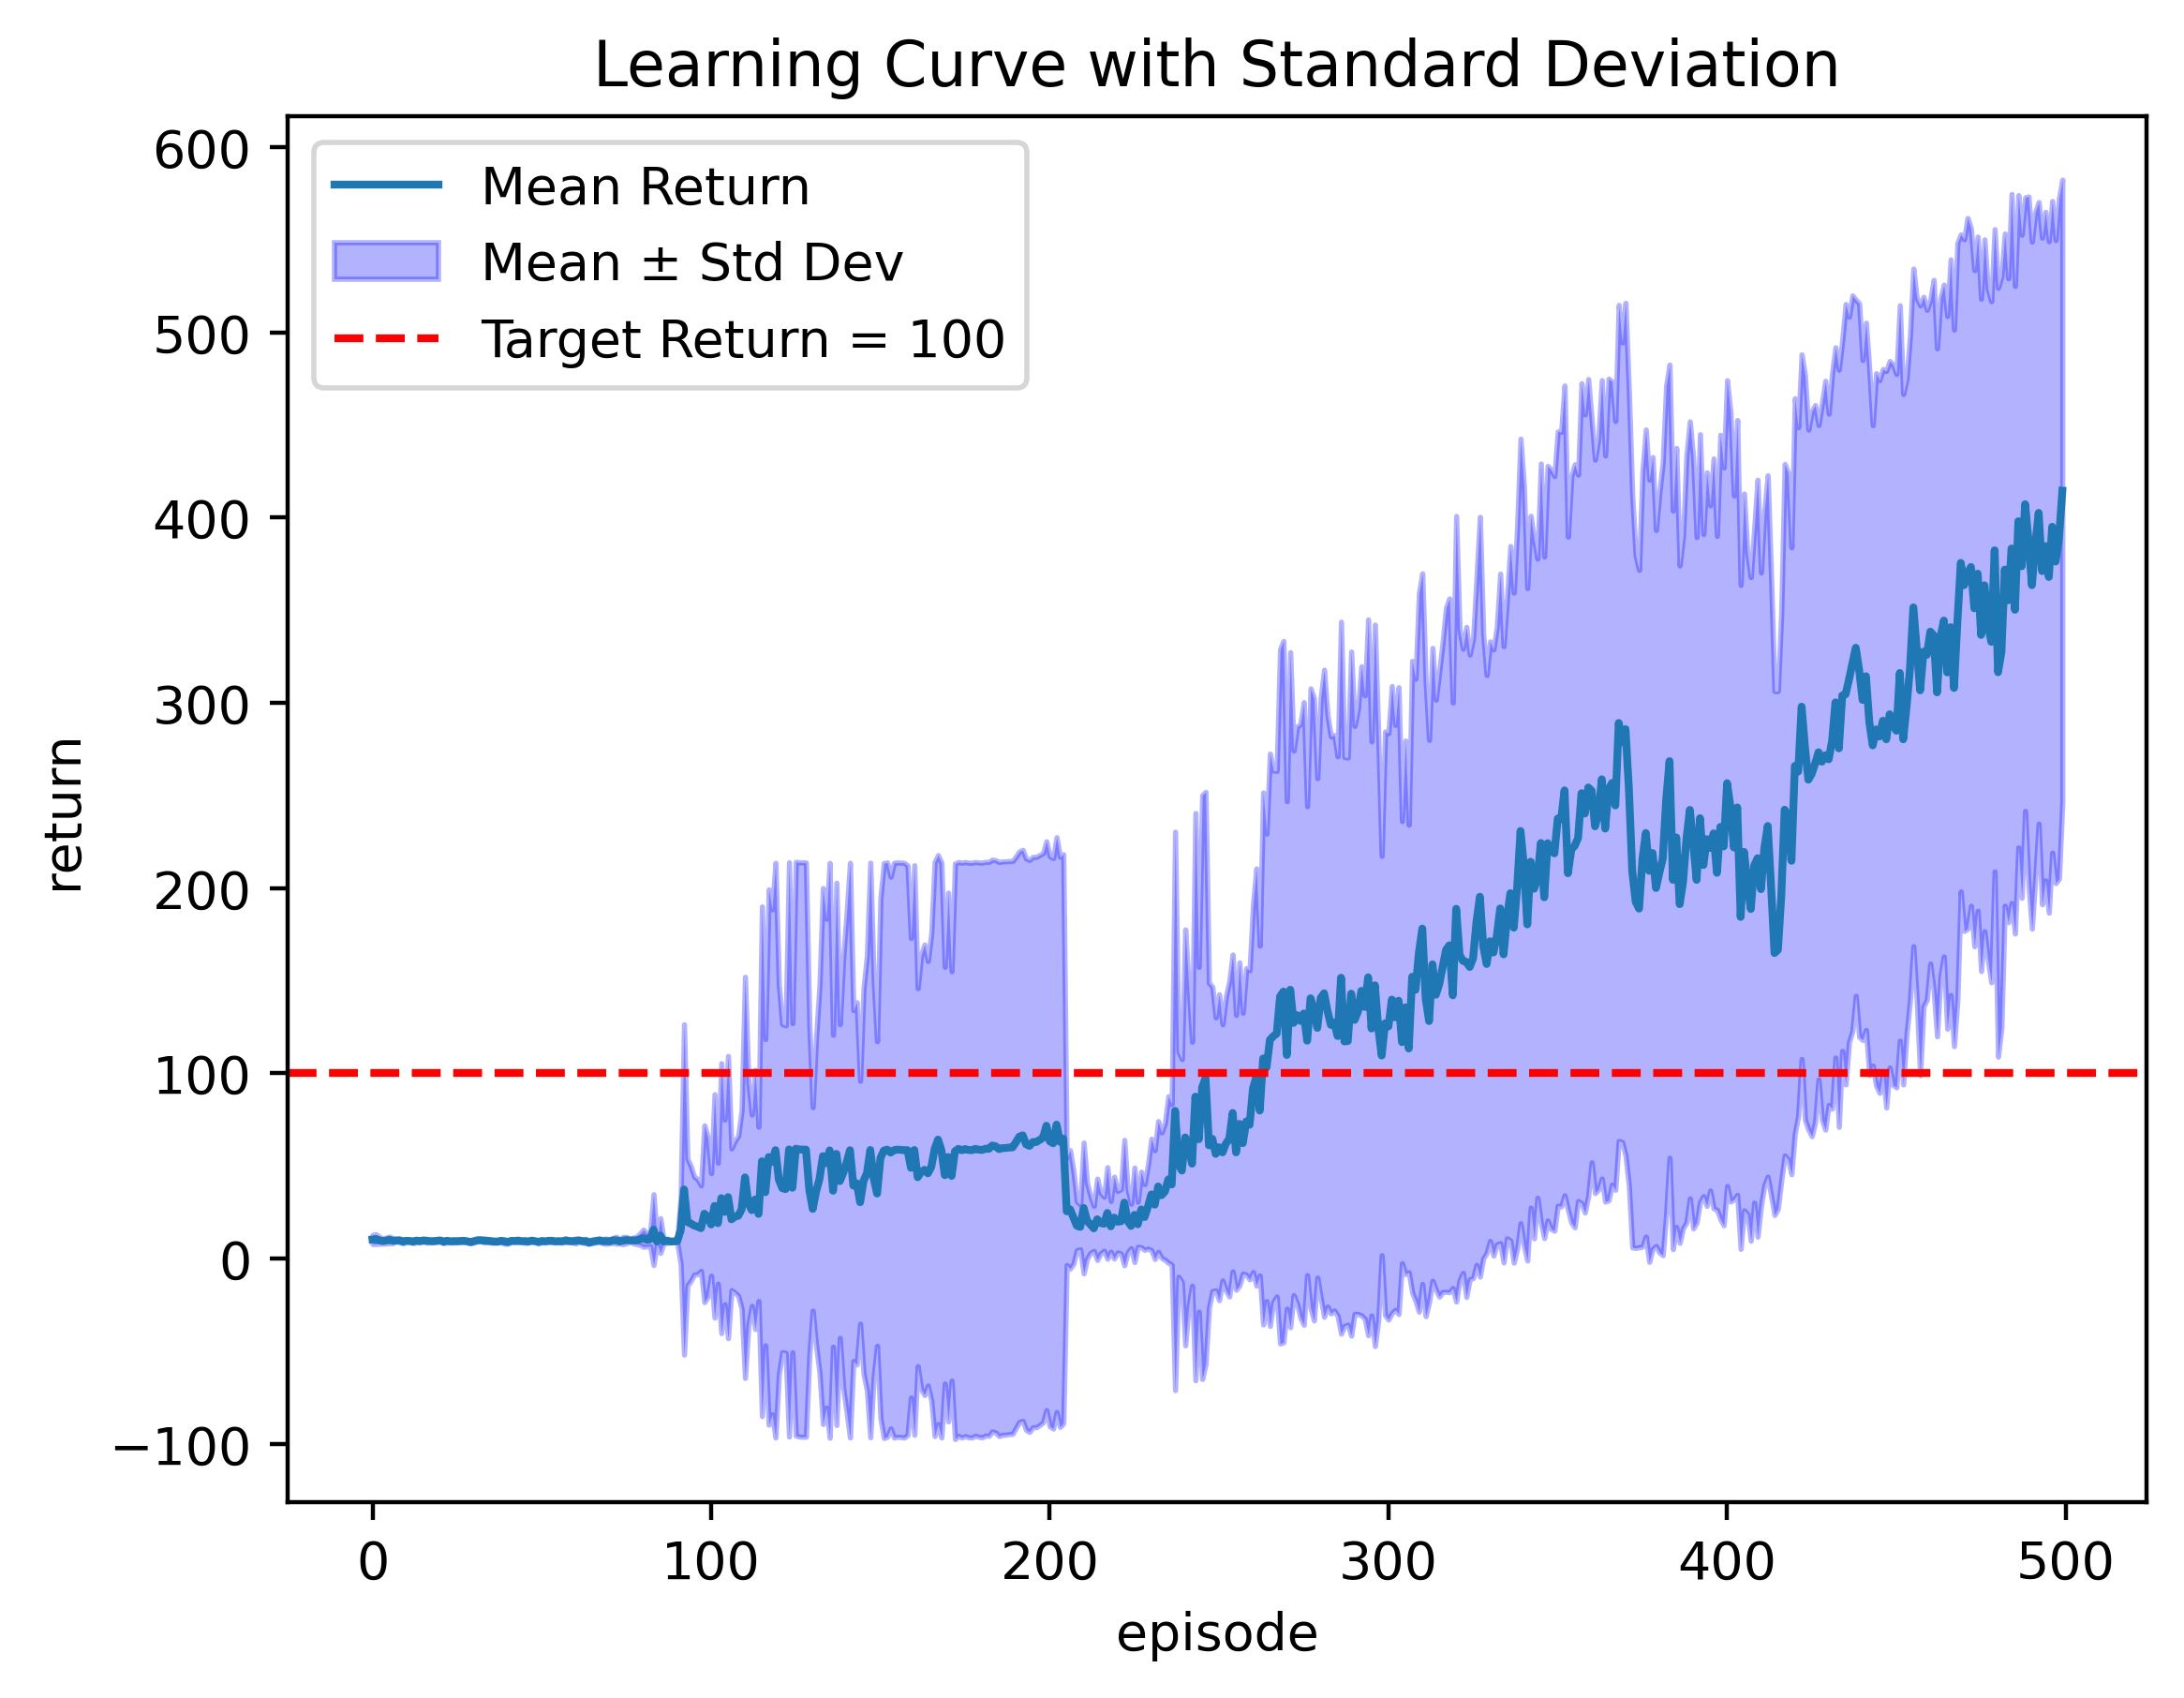

In [ ]:
# # Plotting the learning curve
# # Placeholder plot, you are free to modify it

# num_episodes = len(runs_results[0])

# results = torch.tensor(runs_results)
# means = results.float().mean(0)
# stds = results.float().std(0)

# plt.plot(torch.arange(num_episodes), means)
# plt.ylabel("return")
# plt.xlabel("episode")
# plt.fill_between(np.arange(num_episodes), means, means+stds, alpha=0.3, color='b')
# plt.fill_between(np.arange(num_episodes), means, means-stds, alpha=0.3, color='b')
# plt.axhline(y=100, linestyle='--', color='red')
# plt.show()
num_episodes = len(runs_results[0])

results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.figure(dpi=400)
plt.plot(torch.arange(num_episodes), means, label="Mean Return")
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(num_episodes), means, means + stds, alpha=0.3, color='b', label="Mean ± Std Dev")
plt.fill_between(np.arange(num_episodes), means, means - stds, alpha=0.3, color='b')
plt.axhline(y=100, linestyle='--', color='red', label="Target Return = 100")
plt.legend(loc='upper left')  # Add a legend to describe each line/region
plt.title("Learning Curve with Standard Deviation")
# Ensure axes are tight
# plt.xlim(0, num_episodes - 1)
# plt.ylim(means.min() - stds.max(), means.max() + stds.max())
plt.show()


In [ ]:
torch.save(policy_net.state_dict(), "trained_policy_net.pt")
torch.save(target_net.state_dict(), "trained_target_net.pt")

## Run one Time

In [ ]:
# RUN One more training
runs_results = []
E = 300
layers = [4] + [A]*B + [2]
policy_net = DQN(layers)
target_net = DQN(layers)
update_target(target_net, policy_net)
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=C)
memory = ReplayBuffer(D)

steps_done = 0

episode_durations = []
F = max(F*eps_decay, 0.005)
for i_episode in range(E):
    if (i_episode+1) % 50 == 0:
        print("episode ", i_episode+1, "/", 300)

    observation = env.reset()
    state = torch.tensor(observation).float()

    done = False
    terminated = False
    t = 0
    while not (done or terminated):

        # Select and perform an action
        action = epsilon_greedy(F, policy_net, state)

        observation, reward, done, terminated = env.step(action)
        reward = torch.tensor([reward])/G
        action = torch.tensor([action])
        next_state = torch.tensor(observation).reshape(-1).float()

        memory.push([state, action, next_state, reward, torch.tensor([done])])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if not len(memory.buffer) < H:
            transitions = memory.sample(H)
            state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
            # Compute loss
            mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
            # Optimize the model
            optimizer.zero_grad()
            mse_loss.backward()
            optimizer.step()

        if done or terminated:
            episode_durations.append(t + 1)
        t += 1
        steps_done += 1
        # Update the target network, copying all weights and biases in DQN
        if steps_done % I == 0:
                update_target(target_net, policy_net)
    runs_results.append(episode_durations)

episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300


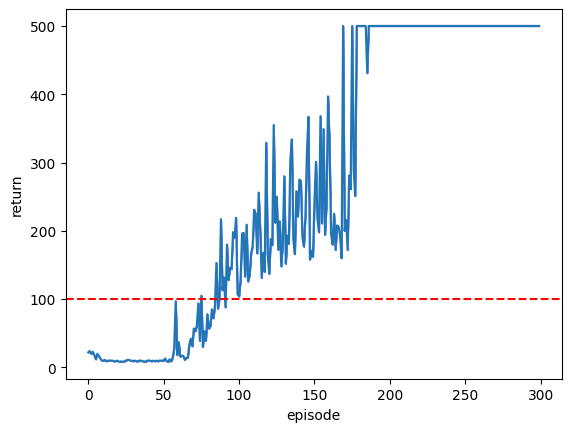

In [ ]:
#Visualizing for one run
# Plotting the learning curve
# Placeholder plot, you are free to modify it

num_episodes = len(runs_results[0])

results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.plot(torch.arange(num_episodes), means)
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(num_episodes), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(num_episodes), means, means-stds, alpha=0.3, color='b')
plt.axhline(y=100, linestyle='--', color='red')
plt.show()

In [ ]:
torch.save(policy_net.state_dict(), "trained_policy_net_best.pt")
torch.save(target_net.state_dict(), "trained_target_net_best.pt")
np.save("run_results_best.npy", np.array(runs_results))

In [ ]:
# policy_net = DQN([4, 128, 128, 2])
# policy_net.load_state_dict(torch.load('trained_policy_net.pt'))
# # policy_net.eval()

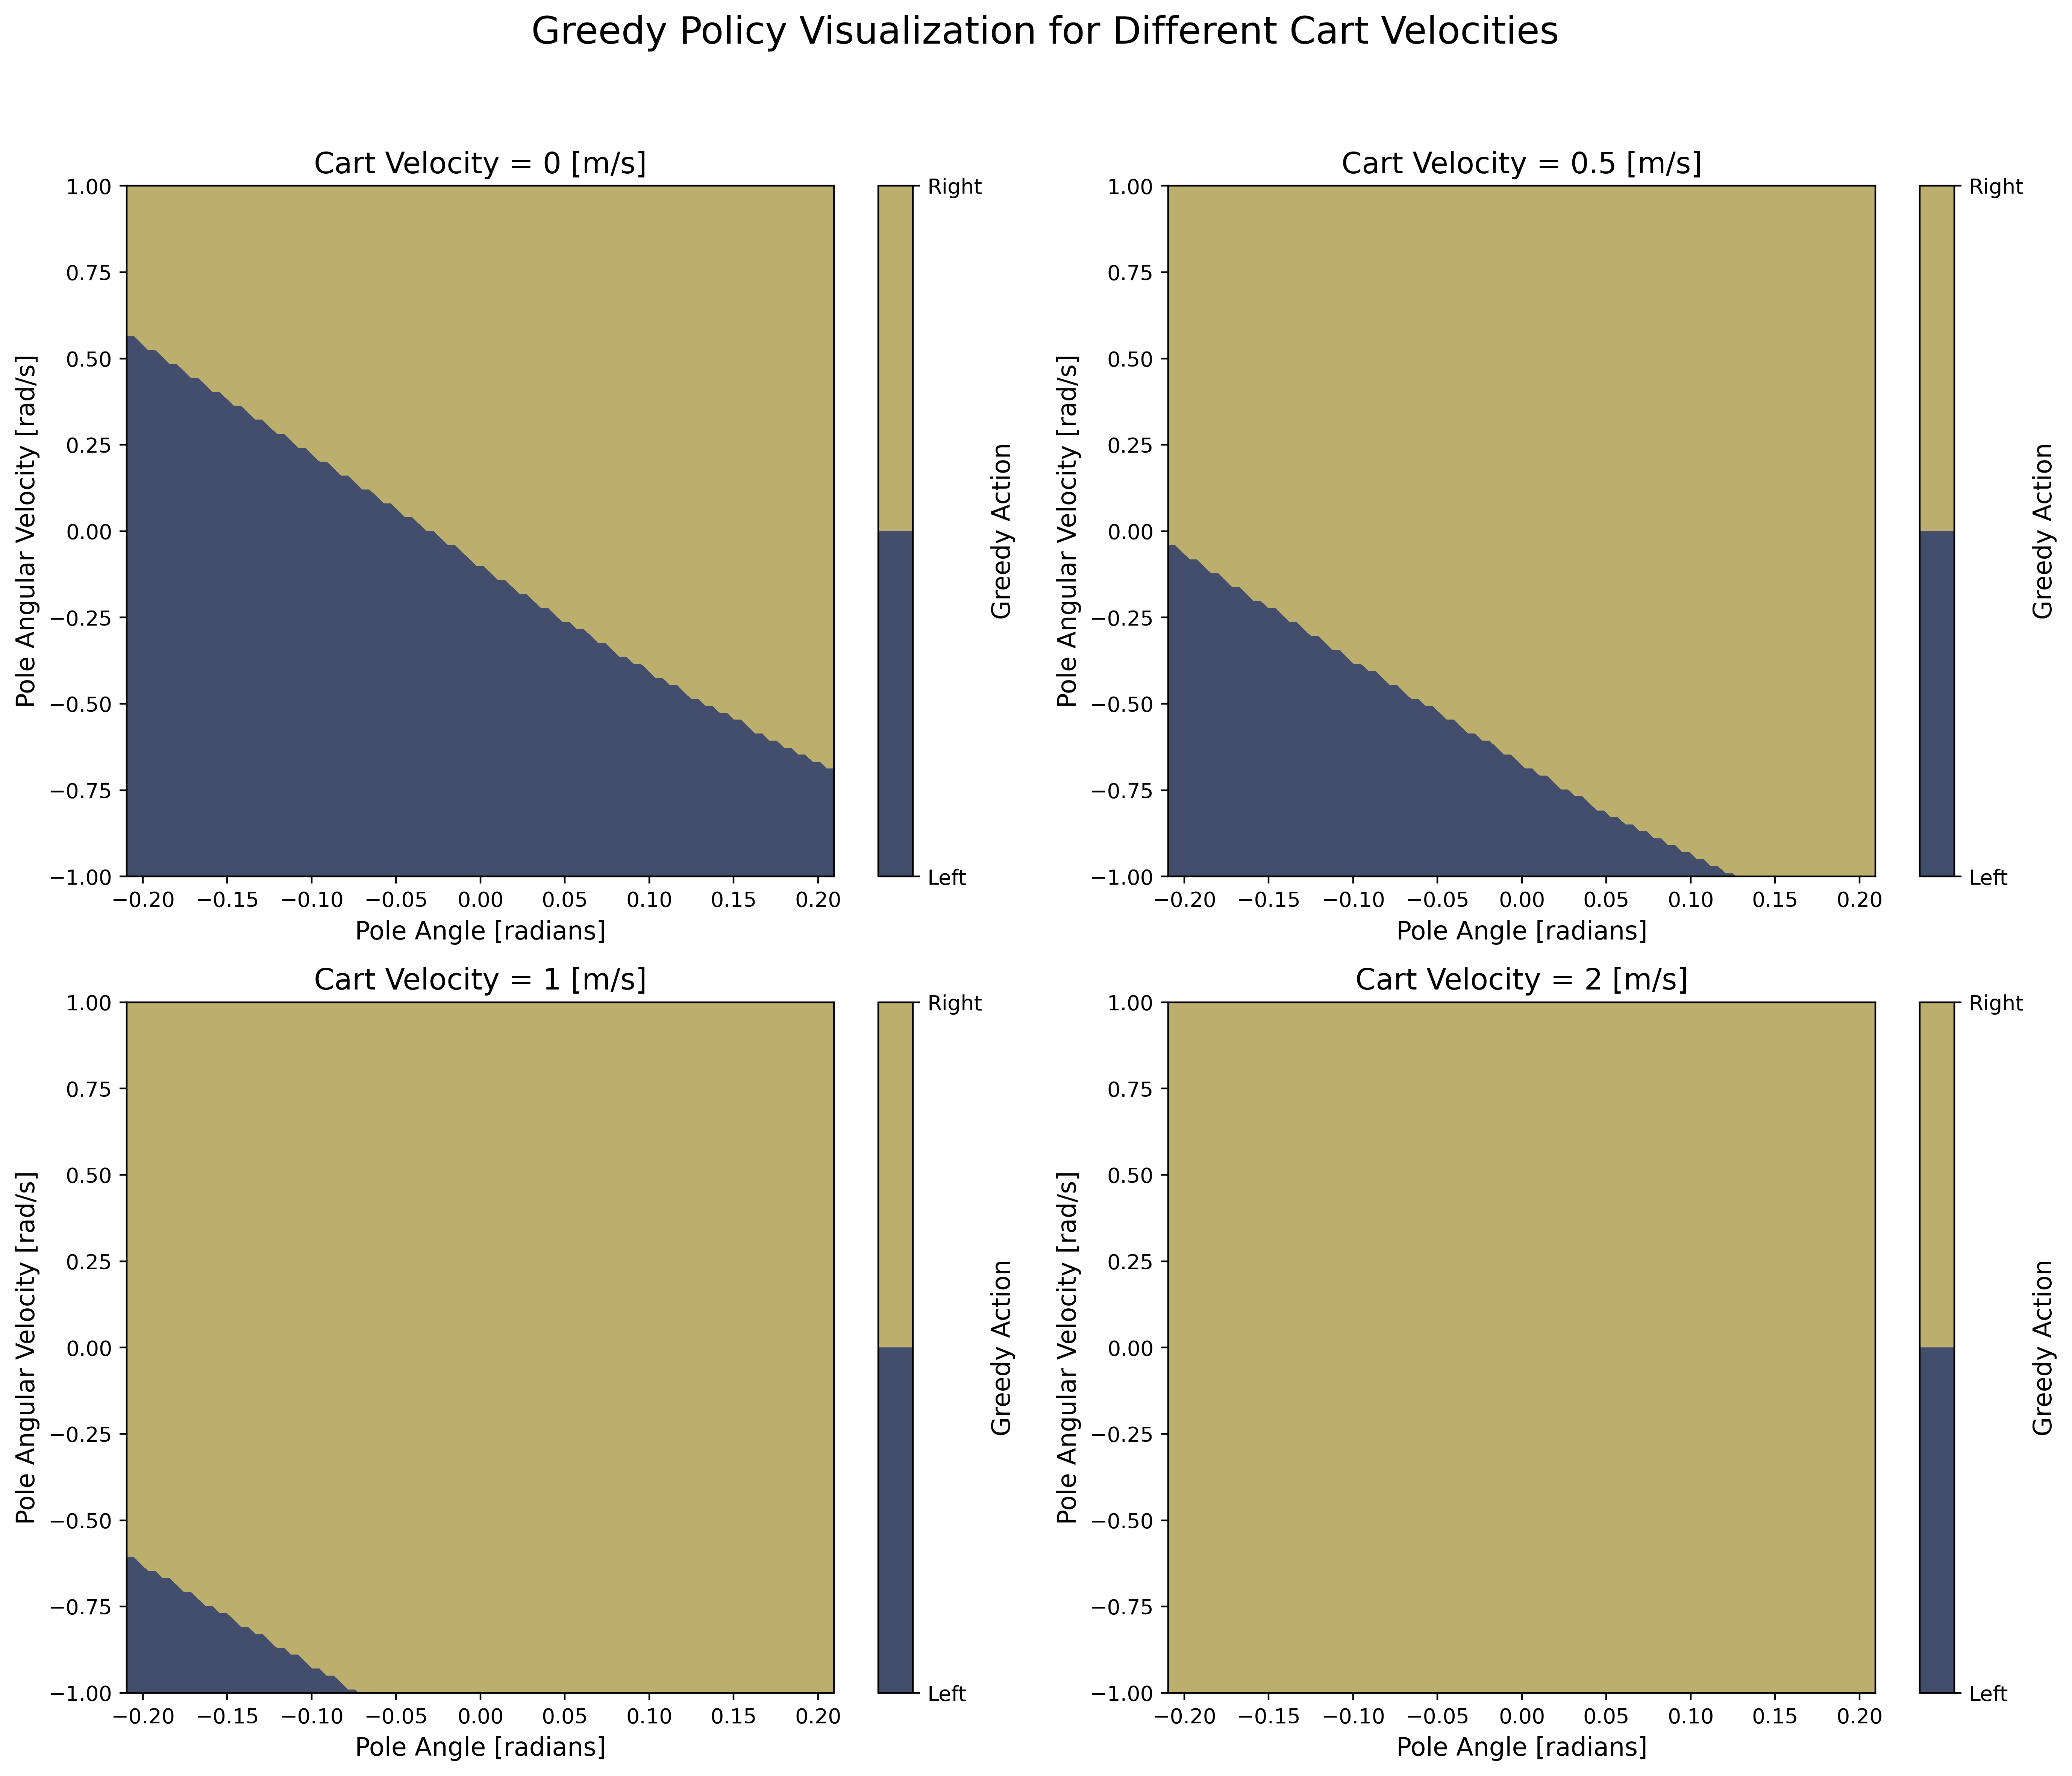

In [ ]:
import torch
import matplotlib.pyplot as plt

# Assume `policy_net` is your trained DQN model
# Replace with your trained policy network

# Parameters for visualization
cart_velocities = [0, 0.5, 1, 2]  # Cart velocities to visualize
angle_range = 0.2095  # Range for pole angle [radians]
omega_range = 1       # Range for pole angular velocity [rad/s]

angle_samples = 100
omega_samples = 100

# Generate sample ranges
angles = torch.linspace(-angle_range, angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(14, 12), dpi=400)  # High DPI for crisp visuals
fig.suptitle("Greedy Policy Visualization for Different Cart Velocities", fontsize=18, y=0.98)

# Iterate over the specified cart velocities
for idx, cart_velocity in enumerate(cart_velocities):
    # Initialize a matrix to store greedy policy values
    policy_array = torch.zeros((angle_samples, omega_samples))

    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            # Create state with fixed cart position (0) and varying velocities
            state = torch.tensor([0., cart_velocity, angle.item(), omega.item()])
            with torch.no_grad():
                q_vals = policy_net(state)  # Get Q-values for the state
                greedy_action = q_vals.argmax()  # Select greedy action
                policy_array[i, j] = greedy_action  # Store greedy policy

    # Determine subplot location
    ax = axs[idx // 2, idx % 2]
    contour = ax.contourf(
        angles, omegas, policy_array.T, cmap='cividis', levels=[0, 0.5, 1]
    )
    ax.set_title(f"Cart Velocity = {cart_velocity} [m/s]", fontsize=14)
    ax.set_xlabel("Pole Angle [radians]", fontsize=12)
    ax.set_ylabel("Pole Angular Velocity [rad/s]", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
     # Add gridlines for clarity
    # ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
    # Add a colorbar to each subplot
    cbar = plt.colorbar(contour, ax=ax, orientation="vertical", pad=0.05)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Left', 'Right'])
    cbar.set_label("Greedy Action", fontsize=12)

# Adjust layout to ensure proper spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


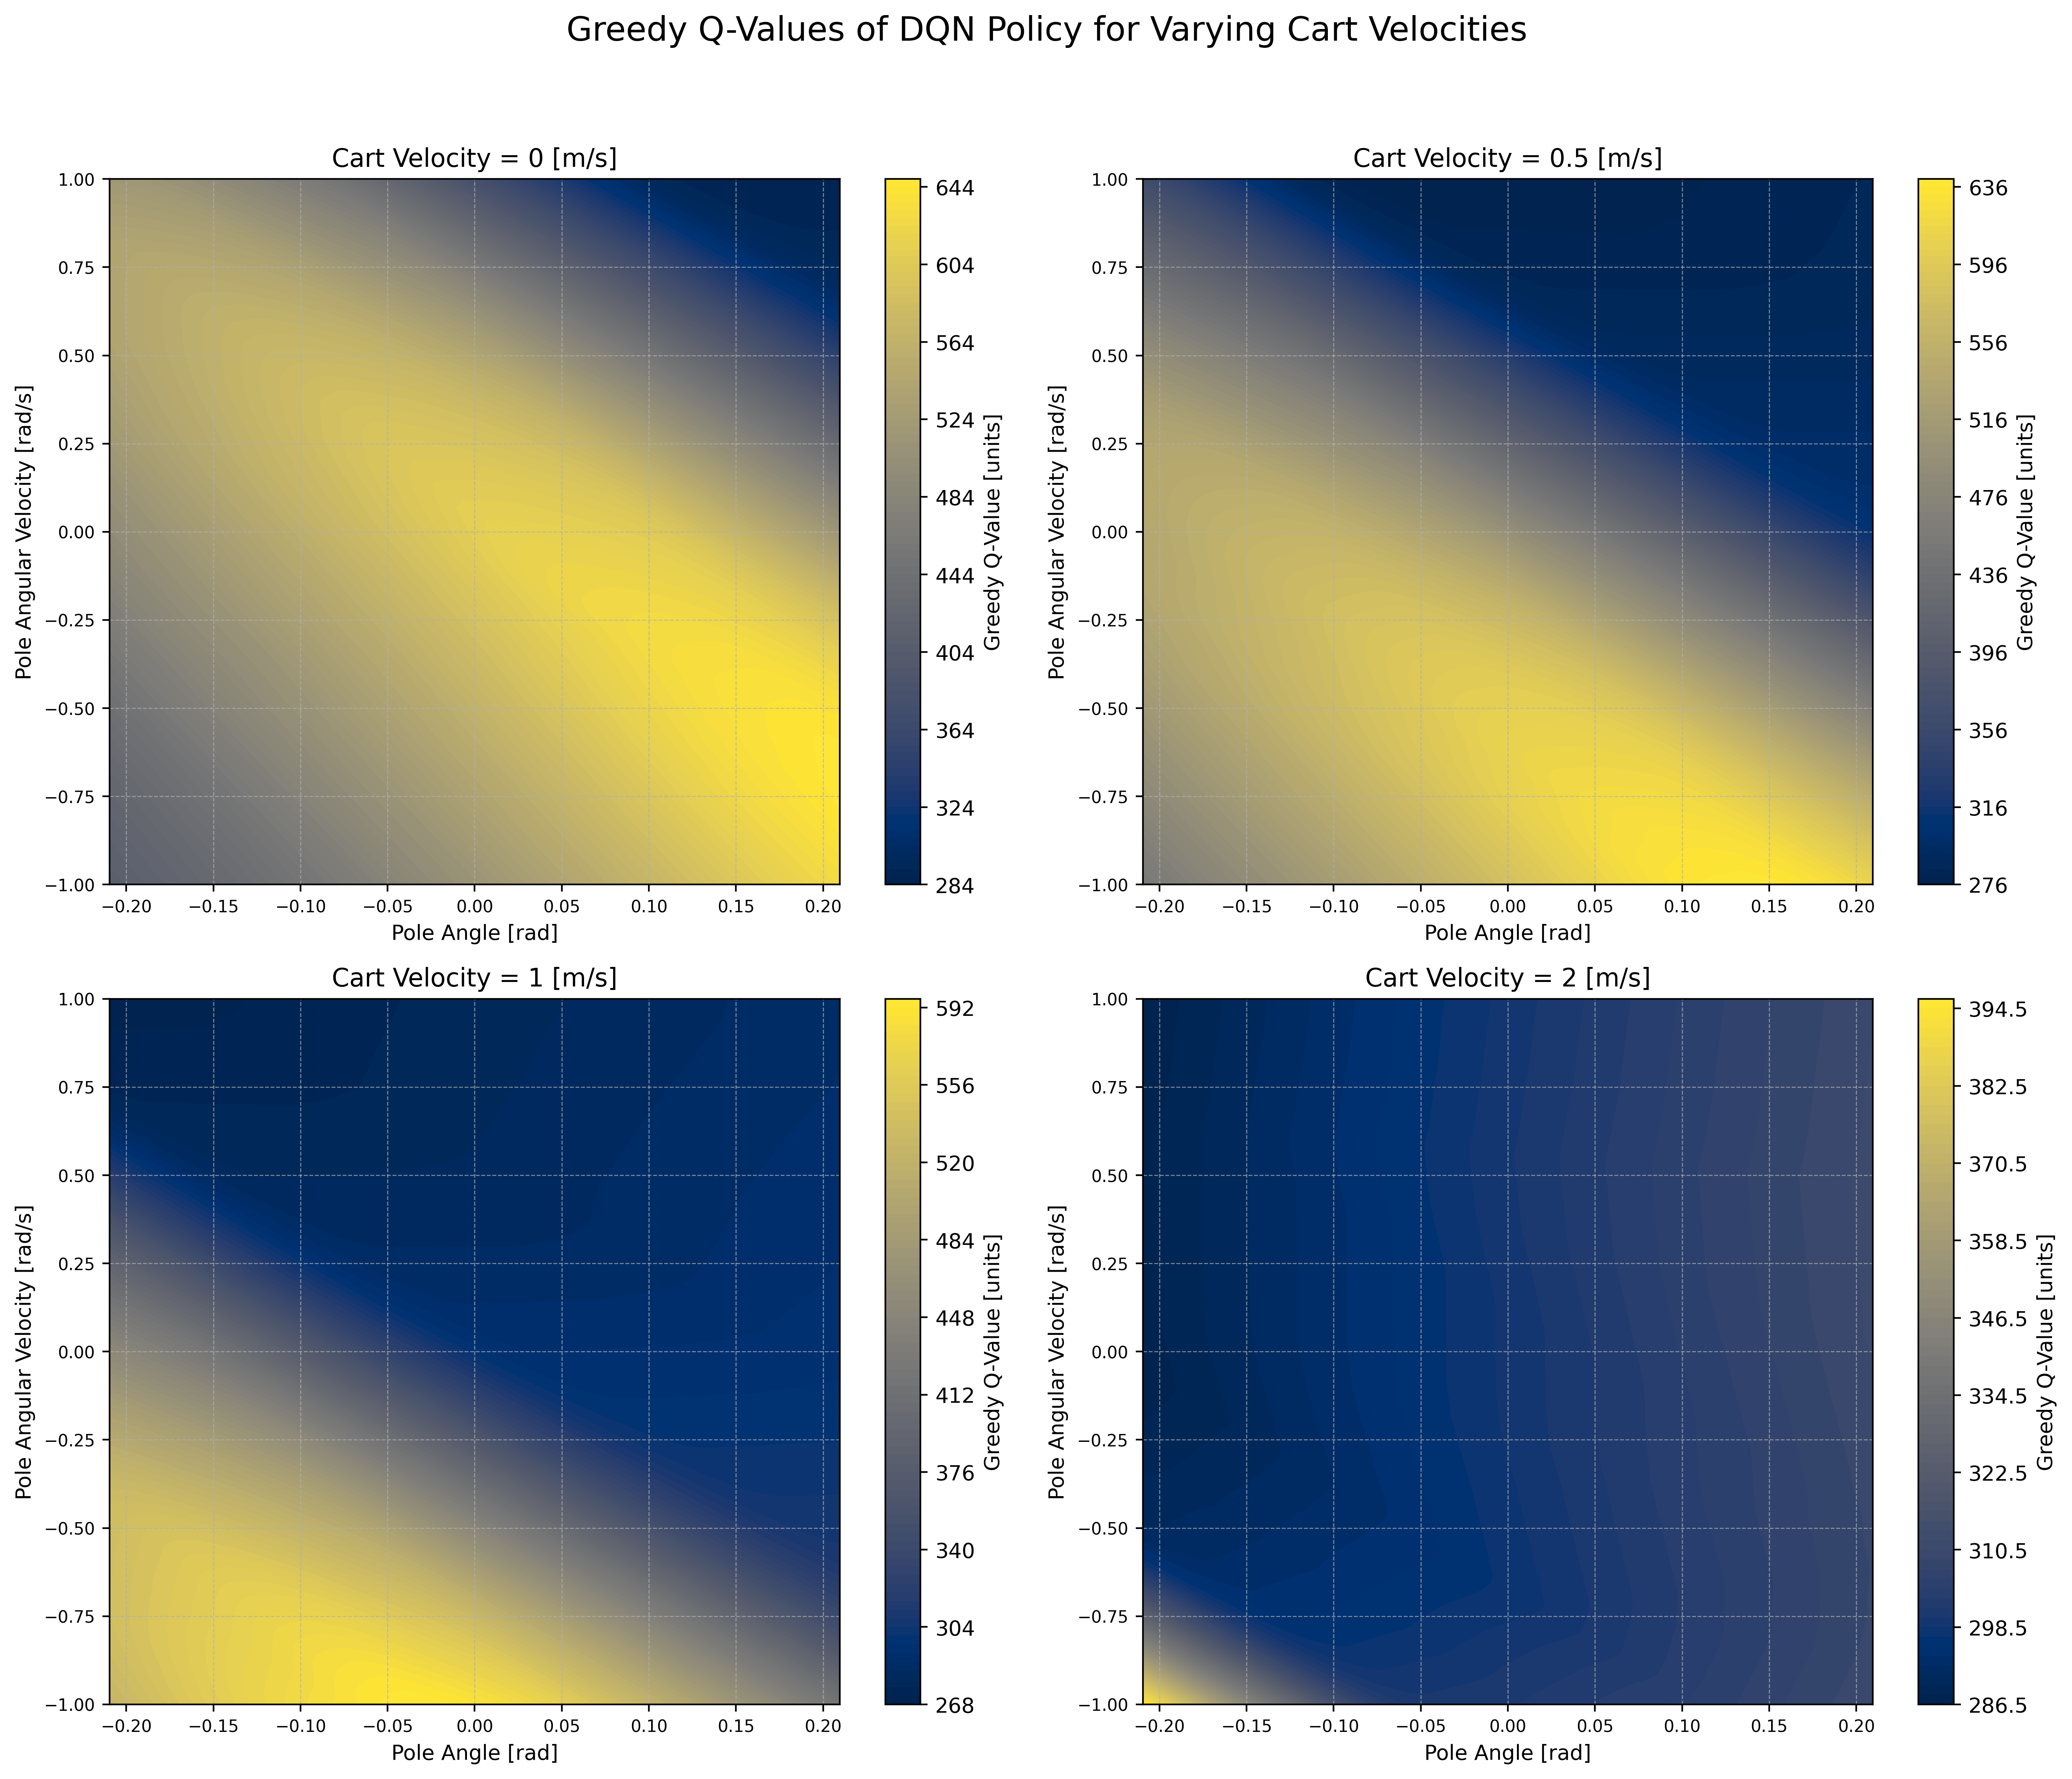

In [ ]:

angle_range = 0.2095  # Pole angle in radians
omega_range = 1.0     # Pole angular velocity in radians per second
angle_samples = 100
omega_samples = 100
angles = torch.linspace(-angle_range, angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)
cart_velocities = [0, 0.5, 1, 2]  # Cart velocities to analyze

# Plotting for each cart velocity
fig, axs = plt.subplots(2, 2, figsize=(14, 12), dpi=400)
fig.suptitle("Greedy Q-Values of DQN Policy for Varying Cart Velocities", fontsize=16)

for idx, cart_velocity in enumerate(cart_velocities):
    # Initialize an array to store greedy Q-values
    greedy_q_values_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            # Create a state tensor with fixed cart position (0) and varying cart velocity
            state = torch.tensor([0.0, cart_velocity, angle.item(), omega.item()])
            with torch.no_grad():
                # Extract the maximum Q-value (greedy Q-value) for this state
                max_q_value = policy_net(state).max().item()
                greedy_q_values_array[i, j] = max_q_value

    # Select the appropriate subplot
    ax = axs[idx // 2, idx % 2]
    # Generate the contour plot
    contour = ax.contourf(
        angles, omegas, greedy_q_values_array.T, cmap='cividis', levels=100
    )
    ax.set_title(f"Cart Velocity = {cart_velocity} [m/s]", fontsize=12)
    ax.set_xlabel("Pole Angle [rad]", fontsize=10)
    ax.set_ylabel("Pole Angular Velocity [rad/s]", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
    # Add individual color bar for each subplot
    cbar = plt.colorbar(contour, ax=ax, orientation="vertical", pad=0.05)
    cbar.set_label("Greedy Q-Value [units]", fontsize=10)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to include the title and avoid overlap
plt.show()